In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from project_resources.import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import mol_fts, abs_file_path, mol_predict_and_std

importing Jupyter notebook from C:\Users\Lukas\Documents\datacytochromy\project_resources\cytochrome_P450.ipynb


In [8]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
isozymes = ["3A4", "RLM", "HLC"]
data_splits = ["train", "test"]
splitters = ["rand", "scaff", "time"]
rel_paths = {
    "3A4_source": r"project_resources/ChEMBL_3A4.csv",
    "3A4_sep": ";",
    "3A4": r"project_resources/3A4.csv",
    "3A4_train_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_train.csv",
    "3A4_test_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_test.csv",
    "3A4_train_rand": r"project_resources/base_splits/random/3A4_train.csv",
    "3A4_test_rand": r"project_resources/base_splits/random/3A4_test.csv",
    "3A4_train_time": r"project_resources/base_splits/time_split/3A4_train.csv",
    "3A4_test_time": r"project_resources/base_splits/time_split/3A4_test.csv",
    "3A4_jazzy_train_rand": r"project_resources/jazzy_splits/random/3A4_train.csv",
    "3A4_jazzy_test_rand": r"project_resources/jazzy_splits/random/3A4_test.csv",
    "3A4_jazzy_train_scaff": r"project_resources/jazzy_splits/scaffold_splitter/3A4_train.csv",
    "3A4_jazzy_test_scaff": r"project_resources/jazzy_splits/scaffold_splitter/3A4_test.csv",
    "3A4_jazzy_train_time": r"project_resources/jazzy_splits/time_split/3A4_train.csv",
    "3A4_jazzy_test_time": r"project_resources/jazzy_splits/time_split/3A4_test.csv",

    "RLM_source": r"project_resources/AID_1508591_datatable_all.csv",
    "RLM_sep": ",",
    "RLM": r"project_resources/RLM.csv",
    "RLM_train_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_train.csv",
    "RLM_test_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_test.csv",
    "RLM_train_rand": r"project_resources/base_splits/random/RLM_train.csv",
    "RLM_test_rand": r"project_resources/base_splits/random/RLM_test.csv",
    "RLM_train_time": r"project_resources/base_splits/time_split/RLM_train.csv",
    "RLM_test_time": r"project_resources/base_splits/time_split/RLM_test.csv",
    "RLM_jazzy_train_rand": r"project_resources/jazzy_splits/random/RLM_train.csv",
    "RLM_jazzy_test_rand": r"project_resources/jazzy_splits/random/RLM_test.csv",
    "RLM_jazzy_train_scaff": r"project_resources/jazzy_splits/scaffold_splitter/RLM_train.csv",
    "RLM_jazzy_test_scaff": r"project_resources/jazzy_splits/scaffold_splitter/RLM_test.csv",
    "RLM_jazzy_train_time": r"project_resources/jazzy_splits/time_split/RLM_train.csv",
    "RLM_jazzy_test_time": r"project_resources/jazzy_splits/time_split/RLM_test.csv",

    "HLC_source": r"project_resources/AID_1508603_datatable_all.csv",
    "HLC_sep": ",",
    "HLC": r"project_resources/HLC.csv",
    "HLC_train_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_train.csv",
    "HLC_test_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_test.csv",
    "HLC_train_rand": r"project_resources/base_splits/random/HLC_train.csv",
    "HLC_test_rand": r"project_resources/base_splits/random/HLC_test.csv",
    "HLC_train_time": r"project_resources/base_splits/time_split/HLC_train.csv",
    "HLC_test_time": r"project_resources/base_splits/time_split/HLC_test.csv",
    "HLC_jazzy_train_rand": r"project_resources/jazzy_splits/random/HLC_train.csv",
    "HLC_jazzy_test_rand": r"project_resources/jazzy_splits/random/HLC_test.csv",
    "HLC_jazzy_train_scaff": r"project_resources/jazzy_splits/scaffold_splitter/HLC_train.csv",
    "HLC_jazzy_test_scaff": r"project_resources/jazzy_splits/scaffold_splitter/HLC_test.csv",
    "HLC_jazzy_train_time": r"project_resources/jazzy_splits/time_split/HLC_train.csv",
    "HLC_jazzy_test_time": r"project_resources/jazzy_splits/time_split/HLC_test.csv"
}
mol_features = {}
halflives = {}
scaff_split_fts = {}  # structure: {isozyme: [x_train, x_test, y_train, y_test]...}
rand_split_fts = {}
y_test_avg_predictions = {}
stds = {}
rmsds = {}
best_models = {}
# lists of repeatedly needed and\or similar info
# dicts for storing outputs and potentially writing them into a file

In [15]:
# load Jazzy features from csv files or generate the features and save them
for splitter in splitters:
    print("\n")
    print(splitter)
    mol_features[splitter] = {}
    halflives[splitter] = {}
    for isozyme in isozymes:
        mol_features[splitter][isozyme] = {}
        halflives[splitter][isozyme] = {}
        for split in data_splits:
            print(isozyme, split)

            try:
                df = pd.read_csv(rel_paths[f"{isozyme}_jazzy_{split}_{splitter}"])
                cols = df.columns
                data = {}  # all data from csv file (i.e. mol indexes, smiles, half-lives and features)
                for col in cols:
                    data[col] = list(df[col])
                nan_idxs = np.argwhere(np.isnan(data["dgtot"]))
                nan_idxs = [int(idx) for idx in nan_idxs]
                data_clumped = []  # same as data, but in the form [[idx1, smi1, thalf1, fts1], [idx2, smi2, thalf2, fts2],...]]
                for col in cols:
                    for i, foo in zip(range(len(data[col])), data[col]):
                        if len(data_clumped) < i+1:
                            data_clumped.append([])
                        data_clumped[i].append(foo)

                # remove all mols for which Jazzy features generation wasn't successful
                num_pops = 0
                for nan_idx in nan_idxs:
                    data_clumped.pop(nan_idx - num_pops)
                    num_pops += 1
                    print(f"     removed index {nan_idx} corresponding to NaN in {split}")
                print(f"     {len(data_clumped)}, {data_clumped[0]}")

                # filter out only the features
                mol_features[splitter][isozyme][split] = np.array([feature[3:11] for feature in data_clumped])
                halflives[splitter][isozyme][split] = np.array([feature[2] for feature in data_clumped])
                contains_nan = np.any(np.isnan(mol_features[splitter][isozyme][split]))
                print(f"     {mol_features[splitter][isozyme][split][0]}")
                print(f"     {isozyme} mol_features {split} contains NaN: {contains_nan}")

            except FileNotFoundError:
                df = pd.read_csv(rel_paths[f"{isozyme}_{split}_{splitter}"])
                mol_idx = df["index"]
                smiles = df["smiles"]
                halflife = df["half-life"]
                mol_features[splitter][isozyme] = mol_fts(smiles, isozyme)  # calculate mol features for list of smiles
                mol_fts_df = pd.DataFrame()
                mol_fts_df["index"] = mol_idx
                mol_fts_df["smiles"] = smiles
                mol_fts_df["half-life"] = halflife
                present_fts = [feature for feature in mol_features[splitter][isozyme][0]]  # list of all mol features

                # write the value of a given feature for each molecule into df
                for feature in present_fts:
                    single_feature_list = []
                    for i in range(len(mol_features[splitter][isozyme])):
                        if mol_features[splitter][isozyme][i] == mol_features[splitter][isozyme][i]:
                            single_feature_list.append(mol_features[splitter][isozyme][i][feature])
                        else:
                            single_feature_list.append(np.nan)
                    mol_fts_df[feature] = single_feature_list

                mol_fts_df.to_csv(abs_file_path(rel_paths[f"{isozyme}_jazzy_{split}_{splitter}"]), index=False)
                print(f'{rel_paths[f"{isozyme}_jazzy_{split}_{splitter}"]} was created successfully')



rand
3A4 train
     56, [63, 'CC(C)(O)c1cc(F)c2c(c1)C(=O)N(Cc1ccc(Cl)cn1)[C@@]2(OCC1(O)CC1)c1ccc(Cl)cc1', 6.0, 13.1753, 1.4177, 11.3044, -7.3559, -125.8906, -119.4889]
     [  13.1753    1.4177   11.3044   -7.3559 -125.8906 -119.4889]
     3A4 mol_features train contains NaN: False
3A4 test
     14, [23, 'Cc1ncsc1-c1ccc([C@H](CC(=O)NCCCCCCNC(=O)COc2c(-c3csc(N4CCOCC4)n3)ccc(F)c2F)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)C2(F)CC2)C(C)(C)C)cc1', 0.3767, 28.4327, 3.274, 23.4872, -4.0348, -286.1545, -257.0326]
     [  28.4327    3.274    23.4872   -4.0348 -286.1545 -257.0326]
     3A4 mol_features test contains NaN: False
RLM train
     removed index 1047 corresponding to NaN in train
     removed index 1517 corresponding to NaN in train
     2022, [158, 'O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12', 30.0, 8.0486, 0.0, 5.2165, -13.5913, -63.7029, -67.7504]
     [  8.0486   0.       5.2165 -13.5913 -63.7029 -67.7504]
     RLM mol_features train contains NaN: False
RLM test
     removed index 174 c

In [16]:
for splitter in splitters:
    y_test_avg_predictions[splitter] = {}
    stds[splitter] = {}
    rmsds[splitter] = {}
    for isozyme in isozymes:
        print(splitter, isozyme)
        x_train = mol_features[splitter][isozyme]["train"]
        y_train = np.log(halflives[splitter][isozyme]["train"])  # natural log half-lives -> values are less spread out
        x_test = mol_features[splitter][isozyme]["test"]
        y_test = np.log(halflives[splitter][isozyme]["test"])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        y_test_avg_predict, std, rmsd = mol_predict_and_std(models, x_train, x_test, y_train, y_test)
        y_test_avg_predictions[splitter][isozyme] = y_test_avg_predict
        stds[splitter][isozyme] = std
        rmsds[splitter][isozyme] = rmsd
        print(f"     root-mean-square deviations: {rmsds[splitter][isozyme]}\n")

rand 3A4
(56, 6) (56,) (14, 6) (14,)
     best linear hyperparams: ElasticNet(alpha=1e-05, l1_ratio=0)
     best linear hyperparams: ElasticNet(alpha=1e-05)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0)
     best KRR hyperparams: KernelRidge(alpha=0.26366508987303583, gamma=2.9763514416313133e-13,
            kernel='rbf')
     best KRR hyperparams: KernelRidge(alpha=0.023357214690901212, gamma=0.00020691380811147902,
            kernel='rbf')
     best KRR hyperparams: KernelRidge(alpha=0.0006158482110660267, gamma=1.2742749857031322e-06,
            kernel='rbf')
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, n_estimators=200)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, n_estimators=400)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, n_estimators=200)
     best RF hyperparams: RandomForestRegressor(max_features='log2', n_estimators=200)
     best RF hyperparams: RandomForestRegressor(max_

In [17]:
for splitter in splitters:
    print(splitter)
    best_models[splitter] = {}
    for isozyme in isozymes:
        isozyme_rmsds = list(rmsds[splitter][isozyme].values())
        lowest_rmsd = min(isozyme_rmsds)
        best_model_for_isozyme = list(rmsds[splitter][isozyme].keys())[list(rmsds[splitter][isozyme].values()).index(lowest_rmsd)]
        best_models[splitter][isozyme] = best_model_for_isozyme
        print(f"best model for {isozyme}: {best_model_for_isozyme} with rmsd {lowest_rmsd}")

rand
best model for 3A4: GB with rmsd 1.3739137306534905
best model for RLM: RF with rmsd 0.9443608705800587
best model for HLC: KRR with rmsd 0.5158808141503338
scaff
best model for 3A4: KRR with rmsd 1.3266624804484175
best model for RLM: ANN with rmsd 1.1821298972586665
best model for HLC: RF with rmsd 1.238583699967289
time
best model for 3A4: ANN with rmsd 1.8377371578054906
best model for RLM: linear with rmsd 0.9751064711079551
best model for HLC: KRR with rmsd 0.6750342109673303


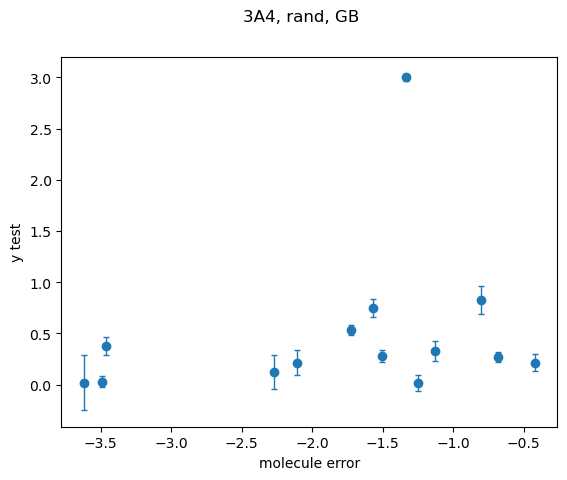

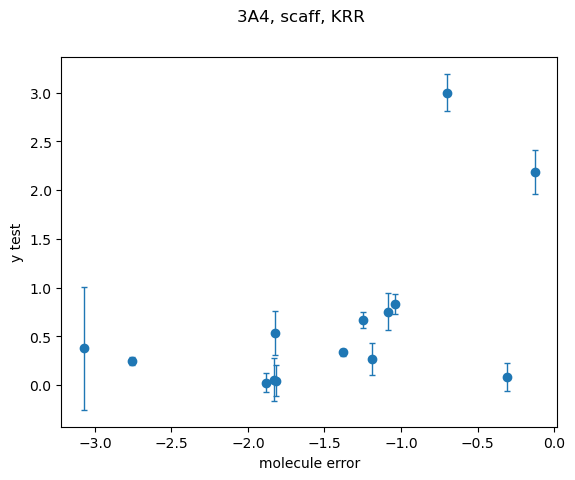

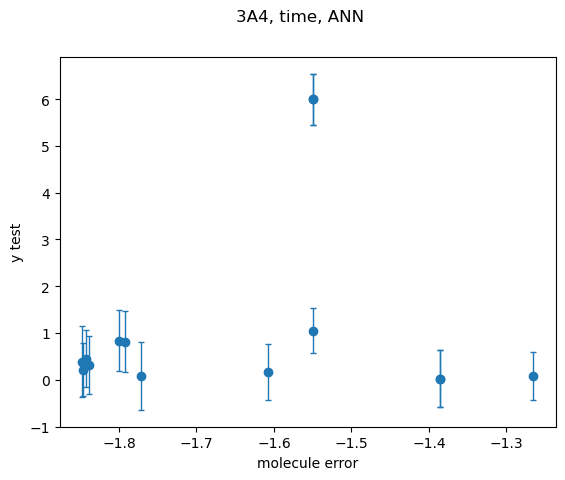

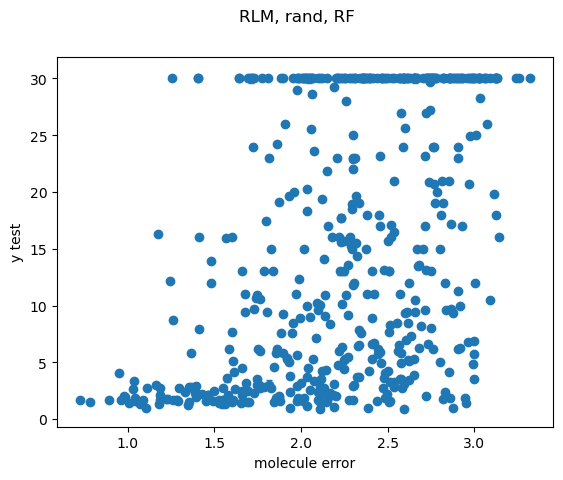

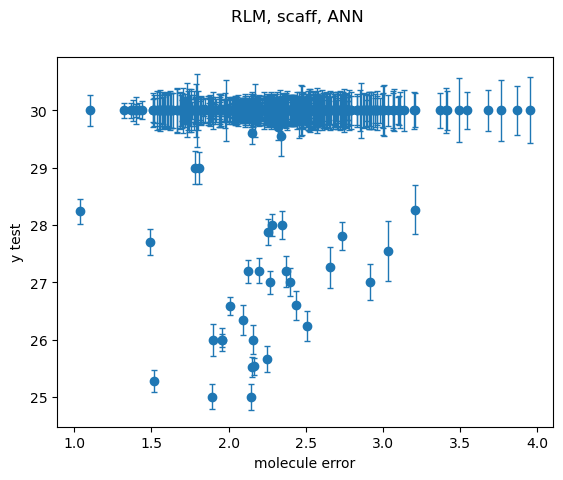

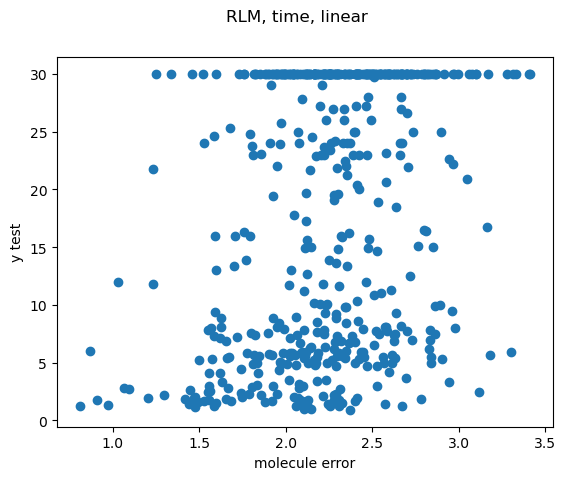

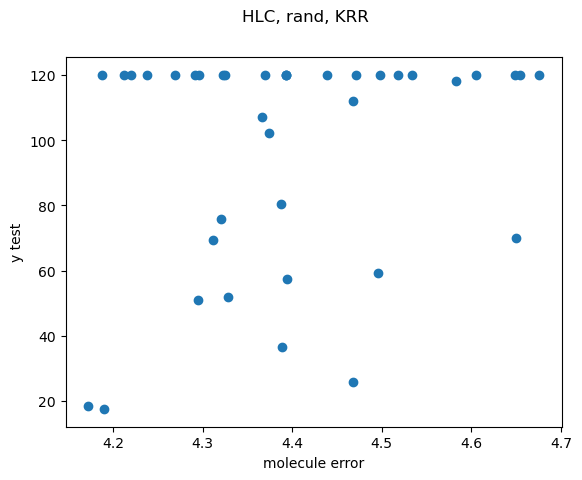

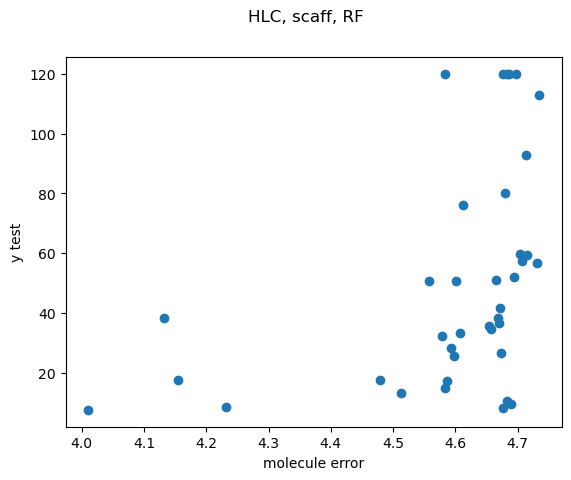

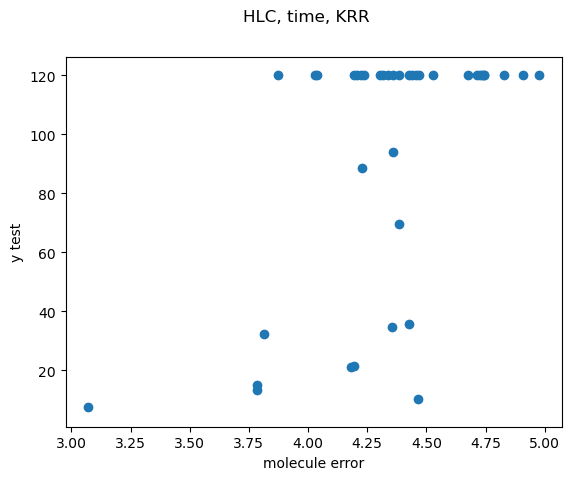

In [18]:
for isozyme in isozymes:
    for splitter in splitters:
        model = best_models[splitter][isozyme]
        plt.clf()
        plt.errorbar(y_test_avg_predictions[splitter][isozyme][model], halflives[splitter][isozyme]["test"],
                     yerr=stds[splitter][isozyme][model], linewidth=1, capsize=2, fmt='o')
        plt.xlabel('molecule error')
        plt.ylabel('y test')
        plt.suptitle(f"{isozyme}, {splitter}, {model}")
        plt.show()